# Test of MoGe and SAM2

### Imports

In [1]:
import os

import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

from moge.model.v2 import MoGeModel
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

### Define devices and functions

In [2]:
device0 = torch.device("cuda:0")
device1 = torch.device("cuda:1")

# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
# turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [3]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

### Load models

In [4]:
sam2_checkpoint = "../models/SAM2/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device0, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [5]:
moge_model = MoGeModel.from_pretrained("../models/MoGe/moge-2-vitl-normal.pt").to(device0)

### Add input image

In [6]:
# Read the input image and convert to tensor (3, H, W) with RGB values normalized to [0, 1]
input_image = cv2.cvtColor(cv2.imread("../data/sample_images/cars.jpg"), cv2.COLOR_BGR2RGB)                       
input_image_tensor = torch.tensor(input_image / 255, dtype=torch.float32, device=device0).permute(2, 0, 1)    
input_image_array  = np.array(input_image)

### Infer segmentation masks and estimate geometry

In [7]:
masks = mask_generator.generate(input_image_array)

In [9]:
output = moge_model.infer(input_image_tensor)
"""
`output` has keys "points", "depth", "mask", "normal" (optional) and "intrinsics",
The maps are in the same size as the input image. 
{
    "points": (H, W, 3),    # point map in OpenCV camera coordinate system (x right, y down, z forward). For MoGe-2, the point map is in metric scale.
    "depth": (H, W),        # depth map
    "normal": (H, W, 3)     # normal map in OpenCV camera coordinate system. (available for MoGe-2-normal)
    "mask": (H, W),         # a binary mask for valid pixels. 
    "intrinsics": (3, 3),   # normalized camera intrinsics
}
"""

'\n`output` has keys "points", "depth", "mask", "normal" (optional) and "intrinsics",\nThe maps are in the same size as the input image. \n{\n    "points": (H, W, 3),    # point map in OpenCV camera coordinate system (x right, y down, z forward). For MoGe-2, the point map is in metric scale.\n    "depth": (H, W),        # depth map\n    "normal": (H, W, 3)     # normal map in OpenCV camera coordinate system. (available for MoGe-2-normal)\n    "mask": (H, W),         # a binary mask for valid pixels. \n    "intrinsics": (3, 3),   # normalized camera intrinsics\n}\n'

### Show outputs

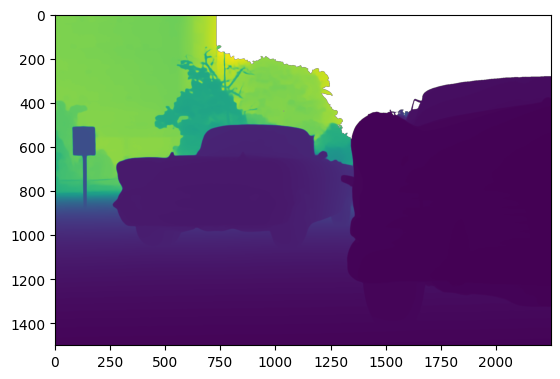

In [10]:
plt.imshow(output["depth"].cpu())

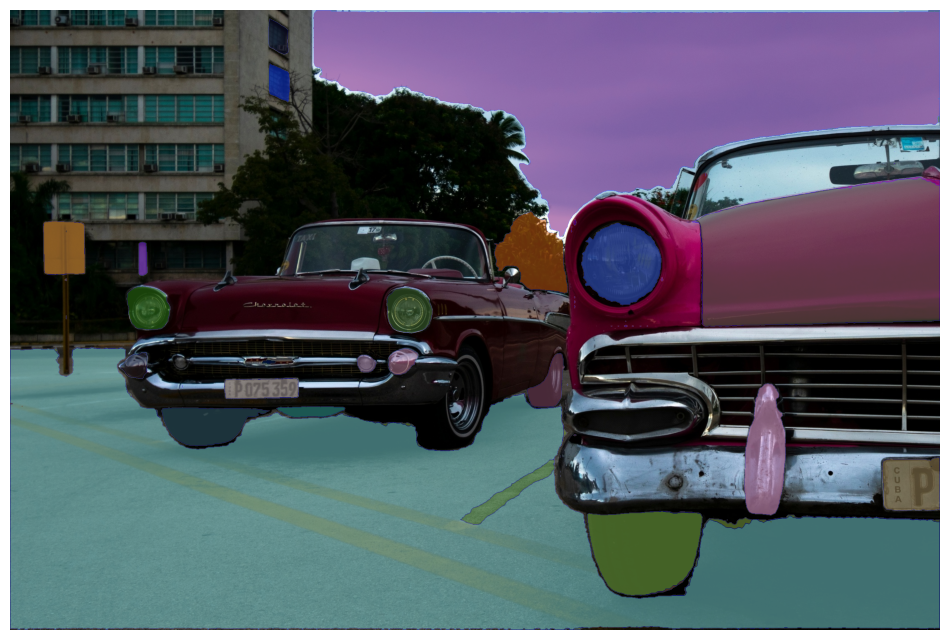

In [11]:
plt.figure(figsize=(12,12))
plt.imshow(input_image_array)
show_anns(masks)
plt.axis('off')
plt.show() 